<a href='https://github.com/SeWonKwon' ><div> <img src ='https://slid-capture.s3.ap-northeast-2.amazonaws.com/public/image_upload/6556674324ed41a289a354258718280d/964e5a8b-75ad-41fc-ae75-0ca66d06fbc7.png' align='left' /> </div></a>


자료 출처 : https://www.kaggle.com/c/house-prices-advanced-regression-techniques

# Data_Load

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/SeWonKwon/ML_training/main/Kaggle/House%20Prices/Data/train.csv')

In [3]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [4]:
def get_df_info(df, short=False):
    print('데이터 세트의 Shape:', df.shape)
    print('\n전체 피처의 dtype\n', df.dtypes.value_counts())
    isnull_series = df.isnull().sum()
    null_column_count = df.isnull().sum()[df.isnull().sum()>0]
    df_null = pd.DataFrame({'dtype':df.dtypes[null_column_count.index], 'count':df.isnull().sum()[df.isnull().sum()>0]})
    
    if short:
        print('\n### Null info short ###')
        display(df_null.sort_values('count',ascending=False).head())
        print('### DF description short ###')
        display(df.describe().T.head())
    else:
        print('\n### Null info ###')
        display(df_null.sort_values('count',ascending=False))
        print('### DF description ###')
        display(df.describe().T)

# Preprocessing

In [5]:
null_columns = df.isnull().sum().sort_values(ascending=False)[:5].index.tolist()
null_columns

['PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu']

In [6]:
# SalePrice 로그 변환
original_SalePrice = df['SalePrice'] # 이전 값 저장
df['SalePrice'] = np.log1p(df.SalePrice)

# Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제
df.drop(['Id']+null_columns, axis=1, inplace=True)

# 드롭하지 않은 숫자형 Null 칼럼은 평균값으로 대체
df.fillna(df.mean(), inplace=True)

In [7]:
df_ohe = pd.get_dummies(df)

# metric 함수 def

In [8]:
from sklearn.metrics import mean_squared_error
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

# LinearRegression

In [9]:
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.model_selection import train_test_split

y_target = df_ohe['SalePrice']
X_features = df_ohe.drop('SalePrice', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

lr_reg = LinearRegression()
rid_reg = Ridge()
las_reg = Lasso()
models = [lr_reg, rid_reg, las_reg]

for model in models:
    model.fit(X_train, y_train)
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.128
Lasso 로그 변환된 RMSE: 0.176


[0.13189576579154055, 0.12750846334053145, 0.17628250556471395]

## result Visualization

In [10]:
def get_top_bottom_coef(model, n=10):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명.
    coef = pd.Series(model.coef_, index=X_features.columns)
    
    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

In [11]:
def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize=(24, 10), nrows = max(len(models)//3, 1) , ncols = 3)
    fig.tight_layout()
    for i, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        axs[i].set_title(model.__class__.__name__ + 'Coeffiecents', size=25)
        axs[i].tick_params(axis='y', direction='in', pad=-120)
        for label in (axs[i].get_xticklabels() + axs[i].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax = axs[i])
        

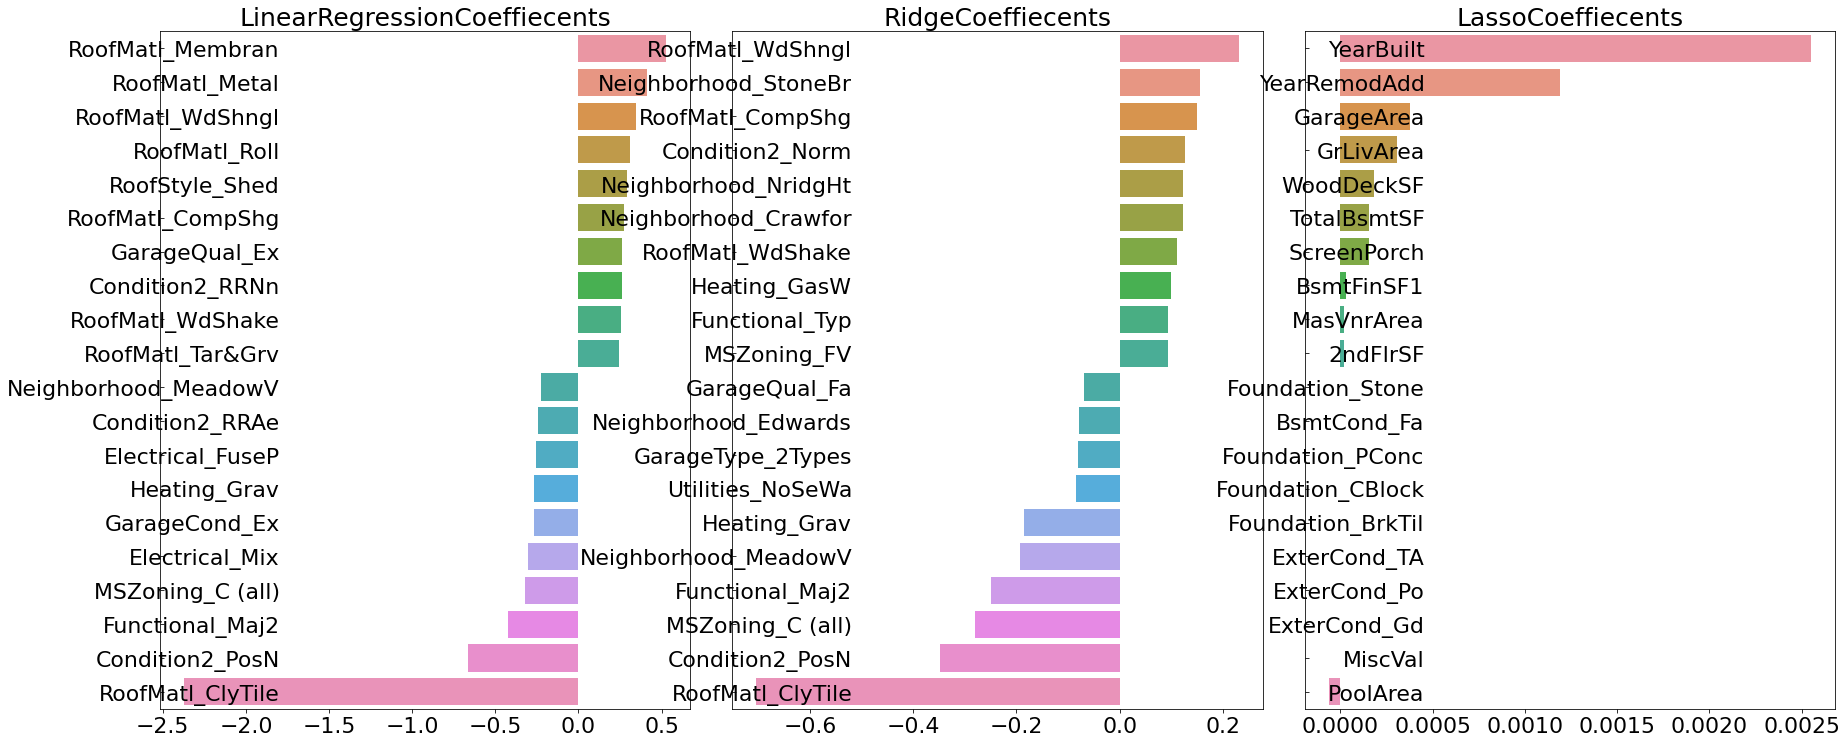

In [12]:
visualize_coefficient(models)

In [13]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할 하지 않고 전체 데이터로 cross_val_score()수행.
        rmse_list = np.sqrt(-cross_val_score(model, X_features,y_target,
                                             scoring='neg_mean_squared_error', cv=5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))

In [14]:
lr_reg = LinearRegression()
rid_reg = Ridge()
las_reg = Lasso()
models = [lr_reg, rid_reg, las_reg]
    
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [1.350000e-01 2.467683e+03 1.680000e-01 1.110000e-01 1.980000e-01]
LinearRegression CV 평균 RMSE 값: 493.659

Ridge CV RMSE 값 리스트: [0.117 0.154 0.142 0.117 0.189]
Ridge CV 평균 RMSE 값: 0.144

Lasso CV RMSE 값 리스트: [0.161 0.204 0.177 0.181 0.265]
Lasso CV 평균 RMSE 값: 0.198


LinearRegression의 경우 비 정상적으로 RMSE값이 커지는데 원인을 못 찾겠다. 

하이퍼 파라미터 조절

In [18]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1*grid_model.best_score_)
    model_name = model.__class__.__name__
    model_best_param = grid_model.best_params_
    print('{0} 5 CV 시 최적 평균 RMSE 값:{1}, 최적 alpha:{2}'.format(model_name, np.round(rmse, 4), model_best_param))
    

In [20]:
ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(rid_reg, ridge_params)
print_best_params(las_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1418, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값:0.142, 최적 alpha:{'alpha': 0.001}


In [21]:
lr_reg = LinearRegression()
rid_reg = Ridge(alpha=12)
las_reg = Lasso(alpha=0.001)
models = [lr_reg, rid_reg, las_reg]

for model in models:
    model.fit(X_train, y_train)
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.132
Ridge 로그 변환된 RMSE: 0.124
Lasso 로그 변환된 RMSE: 0.12


[0.13189576579154055, 0.1238704427998738, 0.11995999974065162]

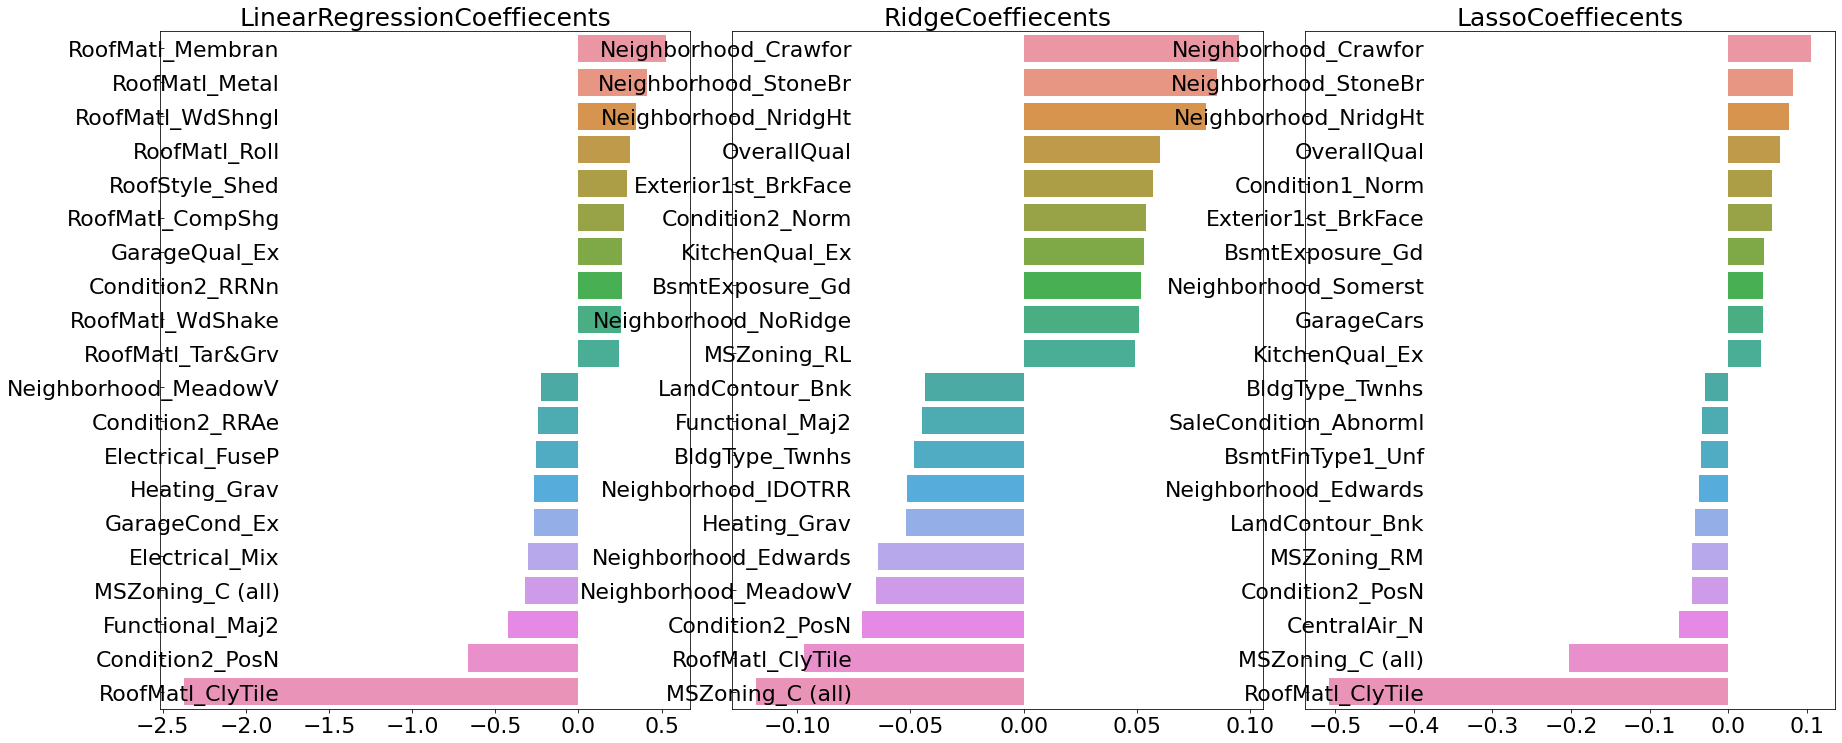

In [22]:
visualize_coefficient(models)

# 모델 튜닝 

## 왜곡된 정도 추출, 
* 사이파이 stats 모듈 skew()함수를 이용해 칼럼의 데이터 세트의 왜곡된 정도를 추출
* 일반적으로 skew() 함수의 반환 값이 1 이상인 경우 왜곡 정도가 높다고 판단.
* 여기서 1 이상의 값을 반환하는 피처만 추출해 왜곡 정도를 완화하기 위해 로그 변환을 적용
* apply lambda 식 skew()를 호출해 숫자형 피처의 왜곡 정도를 구합니다. 

* **주의 사항**
    - 숫자형 피처에만 적용해야 한다. 
    - 원핫 인코딩한 df에 적용하면 안된다. 
    - 카테고리 피처는 코드성 피처이므로 인코딩 시 당연히 왜곡될 가능성이 높습니다. 

In [26]:
from scipy.stats import skew

# object형이 아닌 숫자형 피처의 컬럼 index 객체 추출.
features_index = df.dtypes[df.dtypes !='object'].index

# df에 컬럼 index를 []로 입력하면 해당하는 컬럼 데이터 셋 반환
skew_features = df[features_index].apply(lambda x : skew(x))

skew_features

MSSubClass        1.406210
LotFrontage       2.382499
LotArea          12.195142
OverallQual       0.216721
OverallCond       0.692355
YearBuilt        -0.612831
YearRemodAdd     -0.503044
MasVnrArea        2.673661
BsmtFinSF1        1.683771
BsmtFinSF2        4.250888
BsmtUnfSF         0.919323
TotalBsmtSF       1.522688
1stFlrSF          1.375342
2ndFlrSF          0.812194
LowQualFinSF      9.002080
GrLivArea         1.365156
BsmtFullBath      0.595454
BsmtHalfBath      4.099186
FullBath          0.036524
HalfBath          0.675203
BedroomAbvGr      0.211572
KitchenAbvGr      4.483784
TotRmsAbvGrd      0.675646
Fireplaces        0.648898
GarageYrBlt      -0.667488
GarageCars       -0.342197
GarageArea        0.179796
WoodDeckSF        1.539792
OpenPorchSF       2.361912
EnclosedPorch     3.086696
3SsnPorch        10.293752
ScreenPorch       4.117977
PoolArea         14.813135
MiscVal          24.451640
MoSold            0.211835
YrSold            0.096170
SalePrice         0.121222
d

In [28]:
skew_features_top = skew_features[skew_features>1]
skew_features_top.sort_values(ascending=False)

MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64

In [29]:
df[skew_features_top.index] = np.log1p(df[skew_features_top.index])

In [32]:
skew_features = df[features_index].apply(lambda x : skew(x))

skew_features.sort_values(ascending=False)

PoolArea         14.348342
3SsnPorch         7.727026
LowQualFinSF      7.452650
MiscVal           5.165390
BsmtHalfBath      3.929022
KitchenAbvGr      3.865437
ScreenPorch       3.147171
BsmtFinSF2        2.521100
EnclosedPorch     2.110104
BsmtUnfSF         0.919323
2ndFlrSF          0.812194
OverallCond       0.692355
TotRmsAbvGrd      0.675646
HalfBath          0.675203
Fireplaces        0.648898
BsmtFullBath      0.595454
MasVnrArea        0.480626
MSSubClass        0.248741
OverallQual       0.216721
MoSold            0.211835
BedroomAbvGr      0.211572
GarageArea        0.179796
WoodDeckSF        0.153379
SalePrice         0.121222
YrSold            0.096170
1stFlrSF          0.080032
FullBath          0.036524
GrLivArea        -0.006134
OpenPorchSF      -0.023373
LotArea          -0.137263
GarageCars       -0.342197
YearRemodAdd     -0.503044
YearBuilt        -0.612831
BsmtFinSF1       -0.617774
GarageYrBlt      -0.667488
LotFrontage      -0.891060
TotalBsmtSF      -5.149373
d

모델링

In [35]:
df_ohe = pd.get_dummies(df)
y_target = df_ohe['SalePrice']
X_features = df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                    test_size=0.2, random_state=156)


In [36]:
ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(rid_reg, ridge_params)
print_best_params(las_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1275, 최적 alpha:{'alpha': 10}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1252, 최적 alpha:{'alpha': 0.001}


In [37]:
lr_reg = LinearRegression()
rid_reg = Ridge(alpha=10)
las_reg = Lasso(alpha=0.001)
models = [lr_reg, rid_reg, las_reg]

for model in models:
    model.fit(X_train, y_train)
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.128
Ridge 로그 변환된 RMSE: 0.122
Lasso 로그 변환된 RMSE: 0.119


[0.12826037058748932, 0.12249908141301574, 0.11925534799989718]

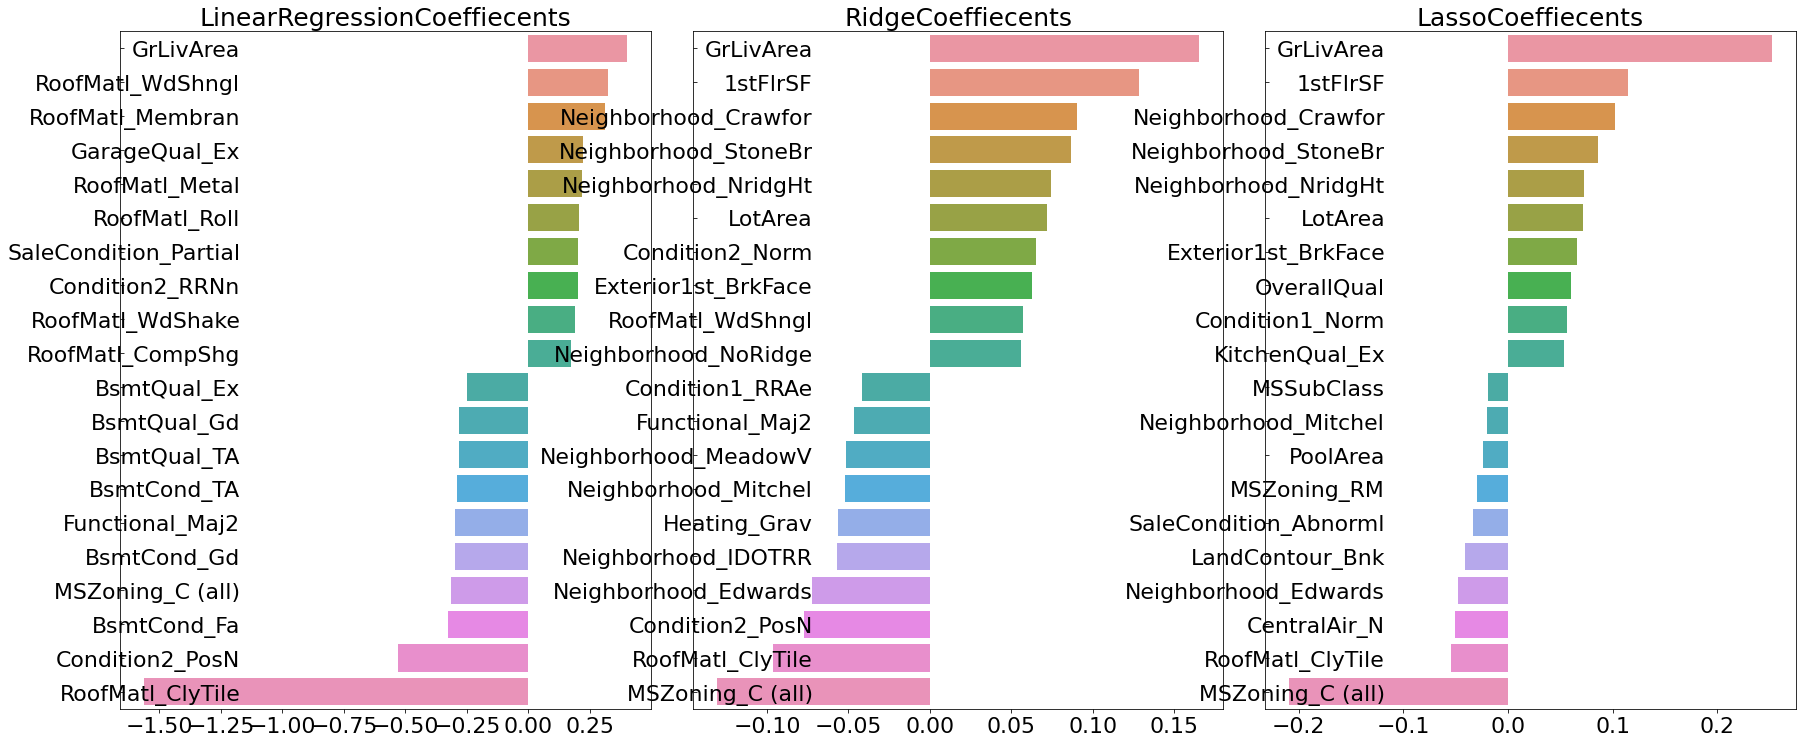

In [38]:
visualize_coefficient(models)

## 이상치 제거

In [39]:
df_org = pd.read_csv('https://raw.githubusercontent.com/SeWonKwon/ML_training/main/Kaggle/House%20Prices/Data/train.csv')

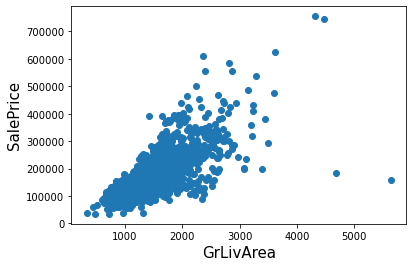

In [40]:
plt.scatter(x=df_org['GrLivArea'], y = df_org['SalePrice'] )
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

GrLivArea가 4000평방 피트 이상임에도 가격이 500,000달러 이하인 데이터는 모두 잇아치로 간주하고 삭제 하겠습니다. 

In [42]:
cond1 = df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = df_ohe[cond1 & cond2].index

In [43]:
outlier_index

Int64Index([523, 1298], dtype='int64')

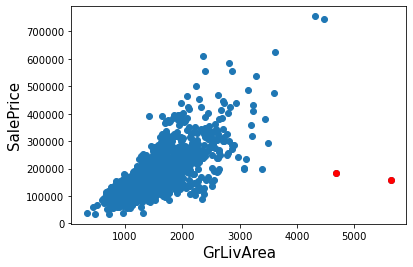

In [51]:
plt.scatter(x=df_org['GrLivArea'], y = df_org['SalePrice'] )
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.scatter(x=df_org.iloc[outlier_index]['GrLivArea'], y=df_org.iloc[outlier_index]['SalePrice'], color='r',)
plt.show()

In [54]:
df_ohe.drop(outlier_index, axis=0, inplace=True)
y_target = df_ohe['SalePrice']
X_features = df_ohe.drop('SalePrice', axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target,
                                                    test_size=0.2, random_state=156)


In [55]:
ridge_params = {'alpha': [0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha': [0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(rid_reg, ridge_params)
print_best_params(las_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값:0.1125, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값:0.1122, 최적 alpha:{'alpha': 0.001}


In [56]:
lr_reg = LinearRegression()
rid_reg = Ridge(alpha=10)
las_reg = Lasso(alpha=0.001)
models = [lr_reg, rid_reg, las_reg]

for model in models:
    model.fit(X_train, y_train)
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 0.129
Ridge 로그 변환된 RMSE: 0.103
Lasso 로그 변환된 RMSE: 0.1


[0.12864941604870547, 0.10313416607869512, 0.10024170460890032]

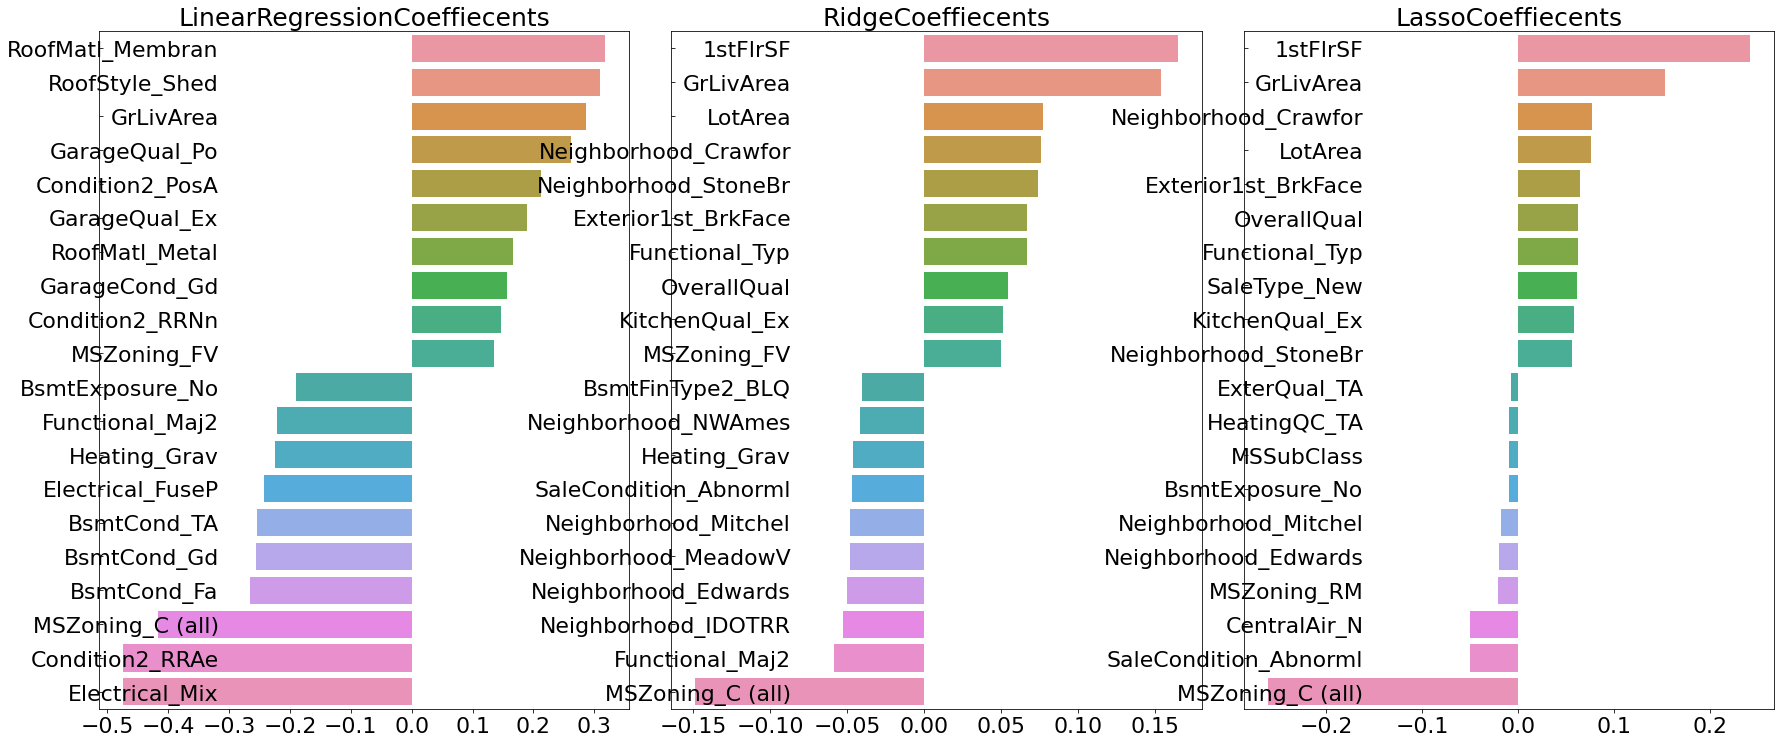

In [57]:
visualize_coefficient(models)

# 회귀 트리 학습/예측/평가

In [59]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimator=1000, learning_rate=0.05,
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)

[08:56:45] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:56:46] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[08:56:48] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in

In [60]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5 CV 시 최적 평균 RMSE 값:0.1163, 최적 alpha:{'n_estimators': 1000}


[09:10:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "n_estimator" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




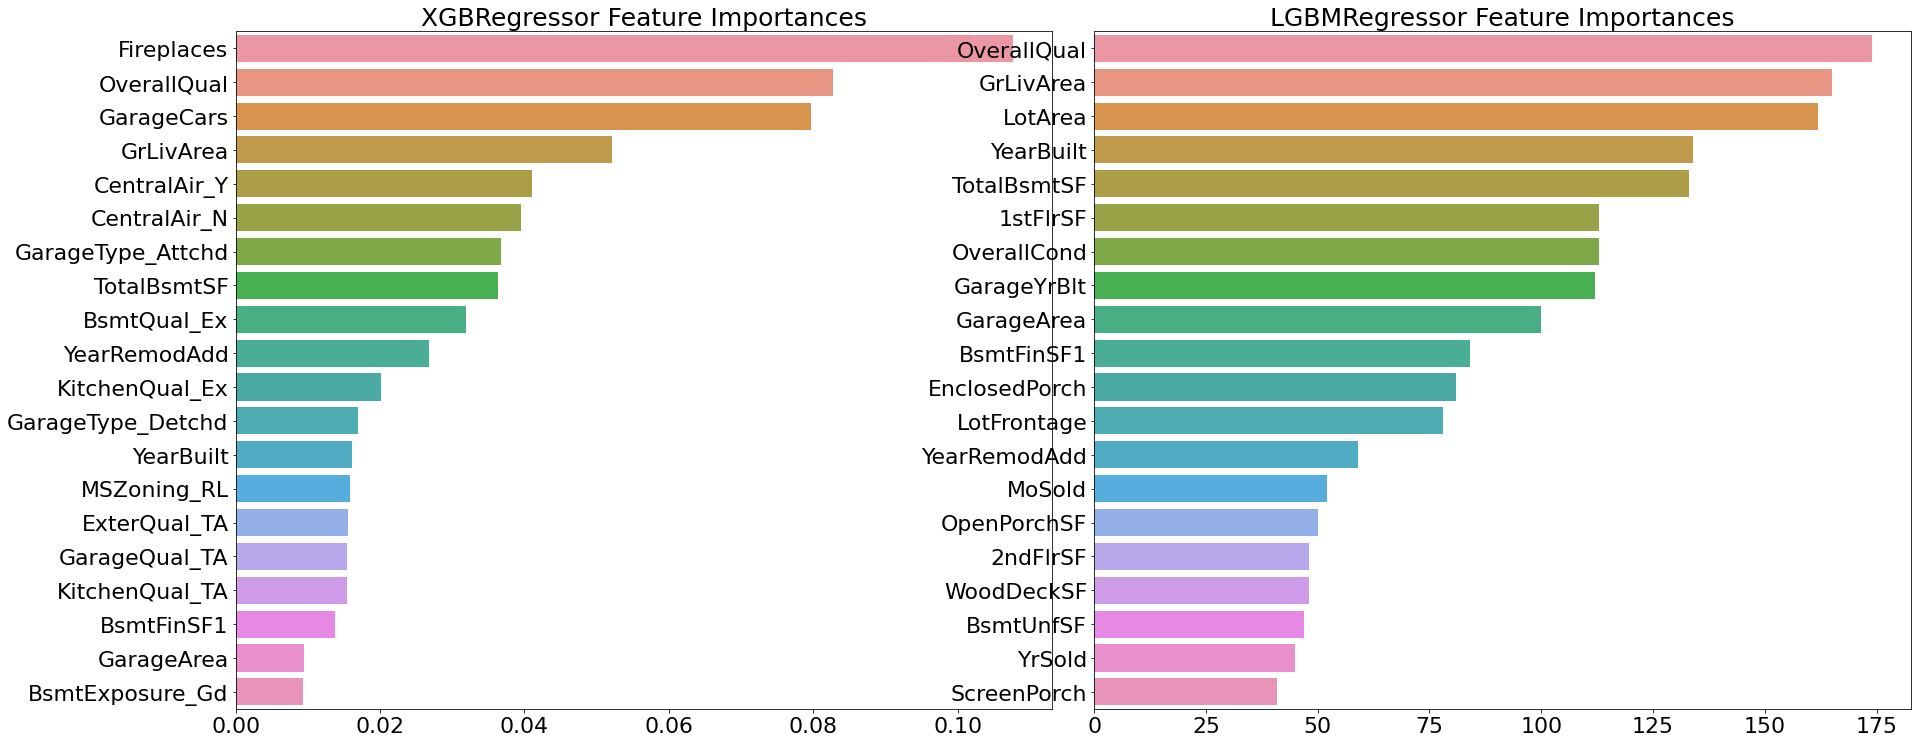

In [66]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화. 
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출 
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 앞 예제에서 print_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화    
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg = XGBRegressor(n_estimator=1000, learning_rate=0.05,
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg.fit(X_features,y_target)
xgb_reg.fit(X_features,y_target)
models = [xgb_reg, lgbm_reg]
visualize_ftr_importances(models)


In [68]:
get_rmses(models)

XGBRegressor 로그 변환된 RMSE: 0.111
LGBMRegressor 로그 변환된 RMSE: 0.07


[0.11118039986254609, 0.06981385562379647]

In [69]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)


최종 혼합 모델의 RMSE: 0.10007930884470506
Ridge 모델의 RMSE: 0.10345177546603253
Lasso 모델의 RMSE: 0.10024170460890032


In [70]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, 
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, 
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.5 * xgb_pred + 0.5 * lgbm_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred}
        
get_rmse_pred(preds)


최종 혼합 모델의 RMSE: 0.10170077353447762
XGBM 모델의 RMSE: 0.10738295638346222
LGBM 모델의 RMSE: 0.10382510019327311


In [71]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수. 
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화 
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    
    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출 
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index] 
        y_tr = y_train_n[train_index] 
        X_te = X_train_n[valid_index]  
        
        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)       
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장. 
        test_pred[:, folder_counter] = model.predict(X_test_n)
            
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성 
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)    
    
    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [72]:
# get_stacking_base_datasets( )은 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환. 
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환. 
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)  
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)



Ridge  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
Lasso  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
XGBRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 
LGBMRegressor  model 시작 
	 폴드 세트:  0  시작 
	 폴드 세트:  1  시작 
	 폴드 세트:  2  시작 
	 폴드 세트:  3  시작 
	 폴드 세트:  4  시작 


In [73]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.  
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, 
                                      xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, 
                                     xgb_test, lgbm_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용. 
meta_model_lasso = Lasso(alpha=0.0005)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)



스태킹 회귀 모델의 최종 RMSE 값은: 0.09799152965189684


**Reference**

* <a href='https://github.com/SeWonKwon' ><div> <img src ='https://slid-capture.s3.ap-northeast-2.amazonaws.com/public/image_upload/6556674324ed41a289a354258718280d/964e5a8b-75ad-41fc-ae75-0ca66d06fbc7.png' align='left' /> </div></a>

<br>

* 파이썬 머신러닝 완벽 가이드, 권철민